### **Designing and implementing a Hidden Markov Model to predict stock prices**
### Implementation
---

### Real Time data scraping from Trading View
TradingView offers free data for various financial instruments across all exchanges in the form of candlestick charts, which include Open, High, Low, Close, and Volume data. Upon analysing its network requests, it becomes evident that TradingView utilises a websocket to request both historical and real-time data. Under the free plan, the most precise tick rate available is 1 minute; premium members, however, have access to 1-second tick rates. Moreover, the free plan restricts access to the past 5000 ticks of data.

Despite these limitations, using a tick rate of 1 day and considering the 5000-tick limit, it is feasible to retrieve historical data spanning up to the previous 19 years of daily price changes for any given financial instrument. For this project, our focus will be on stock prices, which typically exhibit higher liquidity and volatility compared to other financial instruments. This increased volatility can pose challenges for stock price prediction compared to less volatile instruments.

The following piece of code simply requests the required data. Understanding it can be difficult as it requires deep understanding of how the Trading View websocket behaves. All packets are encoded with a \~m\~\<Packet Size\>\~m\~ prefix so the function **WSSend** encodes any data in this format. **GetStockData** takes three input parameters namely the stock symbol name, the tick interval to request at and the number of entries to request. It returns the data in CSV format and a precision variable which describes the precision of the stock prices (this is not used in our project but is used in an application I've created separately which plots stock prices in real time).

The provided code snippet is responsible for requesting essential data from TradingView. Understanding its operation can be challenging due to its dependency on intricate behaviors of the TradingView websocket. Each packet is prefixed with \~m\~\<Packet Size\>\~m\~, a format requirement enforced by TradingView. The function WSSend is designed to encode all data in this specific format.

The function GetStockData accepts three parameters: the stock symbol name, the tick interval for data retrieval, and the number of entries to fetch. It retrieves the requested data in CSV format. Additionally, it returns a precision variable that denotes the level of detail in stock prices. While this precision variable isn't utilised in our current project, it plays a crucial role in another application I've developed, which visualises real-time stock price movements.

In [10]:
import random, time, math, json
from datetime import datetime
from websocket import create_connection

def WSSend(msg, ws):
    ws.send("~m~"+str(len(json.dumps(msg, separators=(',', ':'))))+"~m~"+str(json.dumps(msg, separators=(',', ':'))))

# Timestamp, Open, High, Low, Close, Volume
# Intervals: 1D, 1M, 1W
# Stock: NASDAQ:AMZN

def GetStockData(Stock, Interval, Entries):
    ws = create_connection("wss://data.tradingview.com/socket.io/websocket?from=chart/&date=2024_07_12-13_17&type=chart")
    WSSend({"m":"set_auth_token","p":["unauthorized_user_token"]}, ws)
    WSSend({"m":"set_locale","p":["en","US"]}, ws)
    ChartSession = "cs_"''.join(random.choice('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz') for i in range(12))
    WSSend({"m":"chart_create_session","p":[ChartSession,""]}, ws)
    WSSend({"m":"switch_timezone","p":[ChartSession,"Etc/UTC"]}, ws)
    WSSend({"m":"resolve_symbol","p":[ChartSession,"sds_sym_1","={\"adjustment\":\"splits\",\"session\":\"regular\",\"symbol\":\"" + Stock + "\"}"]}, ws)
    WSSend({"m":"create_series","p":[ChartSession,"sds_1","s1","sds_sym_1",str(Interval),Entries,""]}, ws)
    TicksFound = False
    Data = "Date,Open,High,Low,Close,Volume\n"
    Precision = 0
    while (TicksFound == False):
        msgs = ws.recv()
        if ("~h~" in msgs):
            ws.send("~m~4~m~~h~1")
        else:
            msgs = msgs.split('~m~')
            for msg in msgs:
                if (len(msg) > 0 and '{' in msg):
                    msg = json.loads(msg)
                    if ("m" in msg):
                        if (msg["m"] == "timescale_update"):
                            TicksFound = True
                            for Tick in msg["p"][1]["sds_1"]["s"]:
                                date_obj = datetime.fromtimestamp(Tick["v"][0])
                                Data = Data + str(date_obj) + "," + str(Tick["v"][1]) + "," + str(Tick["v"][2]) + "," + str(Tick["v"][3]) + "," + str(Tick["v"][4]) + "," + str(Tick["v"][5]) + "\n"
                                Precision = str(Tick["v"][4])[::-1].find('.')
                        if (msg["m"] == "series_error"):
                            print("Error")
                            TicksFound = True
    return Data, Precision


---

We use the paper from 2012 (https://users.cs.duke.edu/~bdhingra/papers/stock_hmm.pdf) and (https://ieeexplore.ieee.org/document/6199099) to turn the ideas into python code. We try to implement this to predict a stocks closing price given its open price using a HMM trained on the previous data trends. The paper limits its results findings to large time ticks and suggests the possible exploration into minute-by-minute ticks. Our data scraper allows us to gather real-time stock price data with a 1 minute granularity. Refer to the report (https://brandonsandhu.com/blog/stock-price-prediction-using-hmm) for explanations and analysis about what the following code is doing.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
from hmmlearn.hmm import GaussianHMM

In [11]:
data = pd.read_csv(StringIO(GetStockData("NASDAQ:AAPL", 5, 600)[0]))

In [12]:
trainSize = int(0.8*data.shape[0])

In [13]:
trainData = data.iloc[0:trainSize]
testData = data.iloc[trainSize+1:]

In [14]:
def features(dataframe):
    CloseOpen = (dataframe['Close']-dataframe['Open'])/dataframe['Open']
    HighOpen = (dataframe['High']-dataframe['Open'])/dataframe['Open']
    OpenLow = (dataframe['Open']-dataframe['Low'])/dataframe['Open']
    NewDataframe = pd.DataFrame({'OpenClose': CloseOpen,
                                     'HighOpen': HighOpen,
                                     'LowOpen': OpenLow})
    NewDataframe.set_index(dataframe.index)
    return NewDataframe

def formatFeatures(dataframe):
    return np.column_stack((dataframe['OpenClose'], dataframe['HighOpen'], dataframe['LowOpen']))

In [15]:
trainFeatures = features(trainData)
trainFeaturesFormatted = formatFeatures(trainFeatures)

In [16]:
model = GaussianHMM(n_components=10)

In [17]:
model.fit(trainFeaturesFormatted)

GaussianHMM(n_components=10)

In [18]:
import itertools

OpenClose = trainFeatures['OpenClose']
HighOpen = trainFeatures['HighOpen']
OpenLow = trainFeatures['LowOpen']
    
SampleSpaceOC = np.linspace(OpenClose.min(), OpenClose.max(), 50)
SampleSpaceHO = np.linspace(HighOpen.min(), HighOpen.max(), 10)
SampleSpaceOL = np.linspace(OpenLow.min(), OpenLow.max(), 10)
    
possibleOutcomes = np.array(list(itertools.product(SampleSpaceOC, SampleSpaceHO, SampleSpaceOL)))

In [19]:
numLatentDays = 25
numDaysToPredict = 20

In [20]:
from tqdm import tqdm

predictedClosePrices = []
for i in tqdm(range(numDaysToPredict)):
    # Calculate start and end indices
    previousDataStartIndex = max(0, i - numLatentDays)
    previousDataEndIndex = max(0, i)
    # Acquire test data features for these days
    previousData = formatFeatures(features(testData.iloc[previousDataStartIndex:previousDataEndIndex]))
        
    outcomeScores = []
    for outcome in possibleOutcomes:
        # Append each outcome one by one to see which sequence generates the highest score
        totalData = np.row_stack((previousData, outcome))
        outcomeScores.append(model.score(totalData))
            
    # Take the most probable outcome as the one with the highest score
    mostProbableOutcome = possibleOutcomes[np.argmax(outcomeScores)]
    predictedClosePrices.append(testData.iloc[i]['Open'] * (1 + mostProbableOutcome[0]))

100%|██████████| 20/20 [00:40<00:00,  2.04s/it]


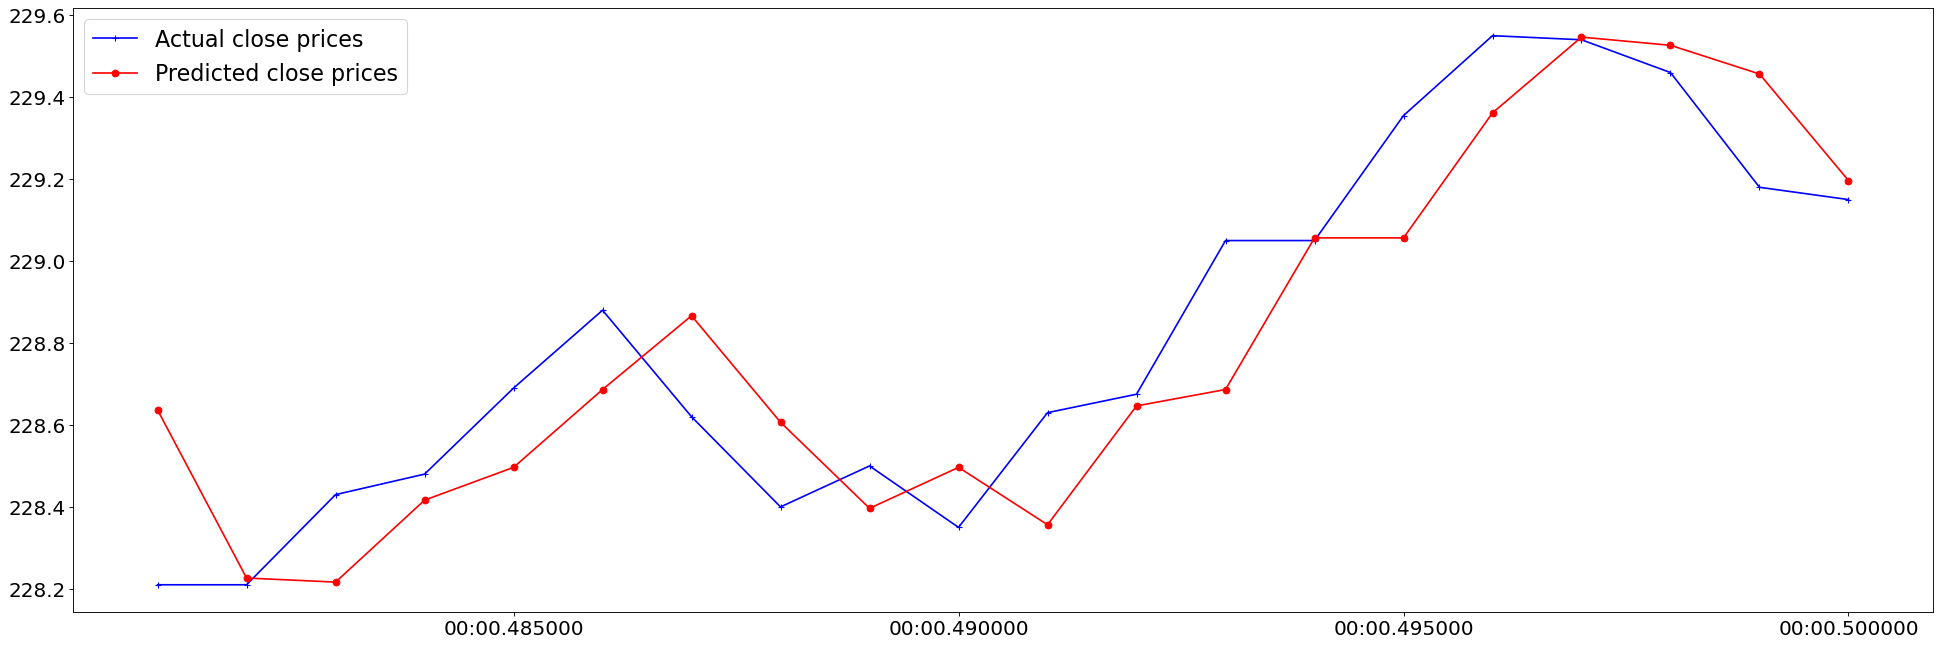

In [21]:
plt.figure(figsize=(30,10), dpi=80)
plt.rcParams.update({'font.size': 18})

xAxis = np.array(testData.index[0:numDaysToPredict], dtype='datetime64[ms]')
plt.plot(xAxis, np.array(testData.iloc[0:numDaysToPredict]['Close']), 'b+-', label="Actual close prices")
plt.plot(xAxis, predictedClosePrices, 'ro-', label="Predicted close prices")
plt.legend(prop={'size': 20})
plt.show()

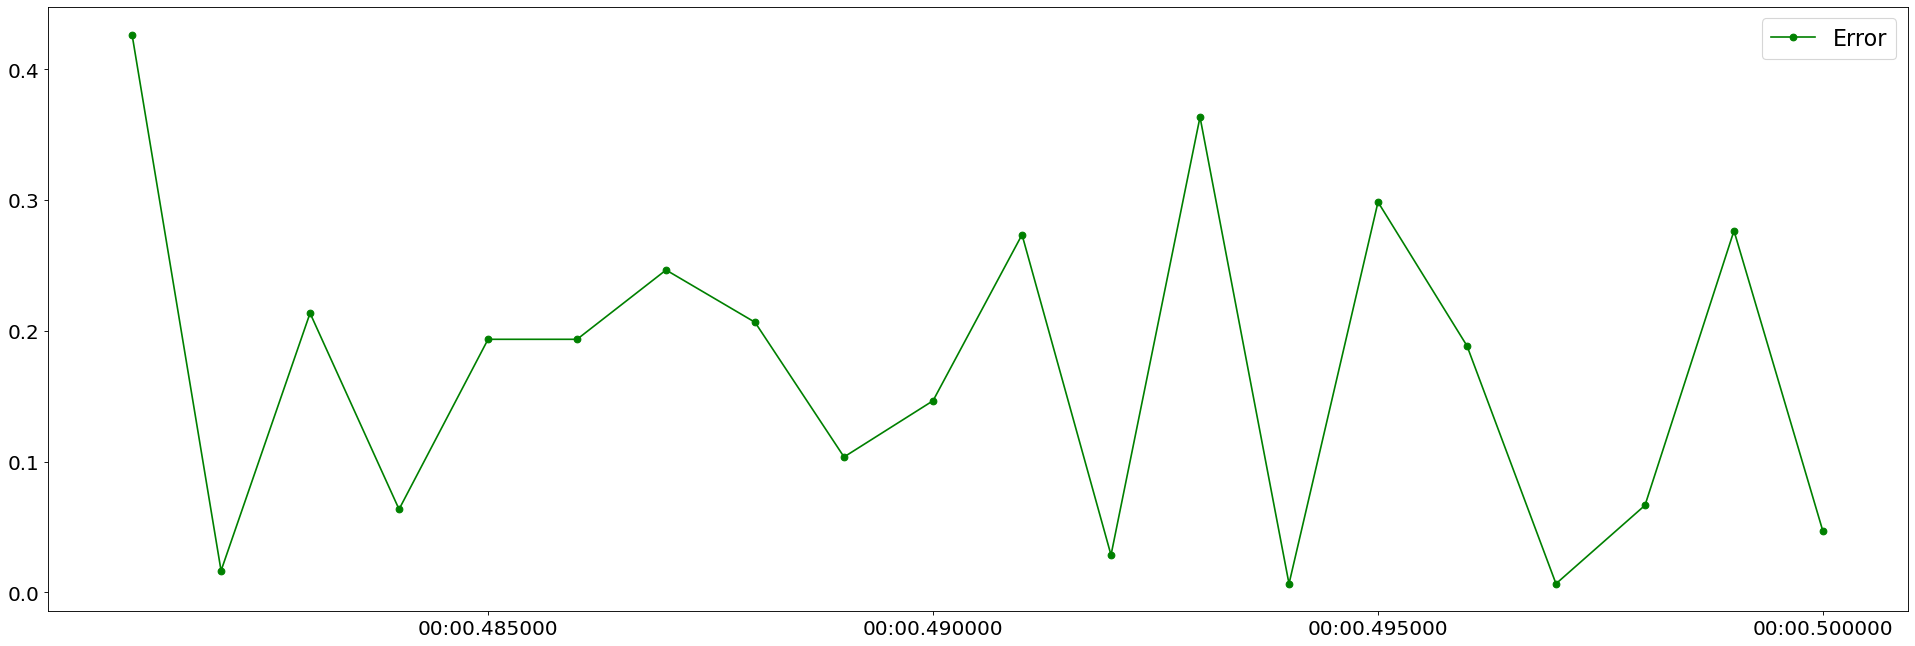

In [22]:
ae = abs(testData.iloc[0:numDaysToPredict]['Close'] - predictedClosePrices)

plt.figure(figsize=(30,10), dpi=80)

plt.plot(xAxis, np.array(ae), 'go-', label="Error")
plt.legend(prop={'size': 20})
plt.show()

In [23]:
print("Max error observed = " + str(ae.max()))
print("Min error observed = " + str(ae.min()))
print("Mean error observed = " + str(ae.mean()))

Max error observed = 0.4265034017418543
Min error observed = 0.006515348681176647
Mean error observed = 0.168254686329162
